In [77]:
#Shishir Khanal
#State Feedback controller in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html
using Pkg;
Pkg.add("ControlSystems");
Pkg.add("Plots");
Pkg.add("LinearAlgebra");
using ControlSystems, Plots, DSP, LinearAlgebra;

   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [14]:
#State Space form for DC joint motor system
#  [x1_dot, x2_dot] = [0 1, 0 (B/J)] * [x1, x2] + [0, 1/J] * u
#  y = [1 0][x1; x2]

In [15]:
begin
    s = tf("s")
    P = 1/(10s^2 + 0.1s)
end

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
     1.0
--------------
10.0s^2 + 0.1s

Continuous-time transfer function model

In [16]:
Pss = ss(P)

StateSpace{Continuous, Float64}
A = 
 0.0   0.5
 0.0  -0.01
B = 
 0.0
 0.5
C = 
 0.4  0.0
D = 
 0.0

Continuous-time state-space model

In [17]:
P₁ = tf(Pss)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
-1.734723475976807e-18s + 0.09999999999999995
---------------------------------------------
               1.0s^2 + 0.01s

Continuous-time transfer function model

In [18]:
#Design a state feedback controller for a simple robot joint w/ J = 10 and B = 0.1. 
#Specify the desired properties of closed-loop system as:
#1. Overshoot less than 5% i.e. ζ ≥ 0.7
#2. rise time less than 0.1 sec i.e. ωₙ ≥ 18 rad/s (tᵣ = 1.8 /ωₙ)

In [19]:
#Investigate Desired Poles
begin 
    ζ = 0.7
    ωₙ = 18
    Δ = s^2 + 2*ζ*ωₙ*s + ωₙ^2
    desired_poles = tzero(Δ)
end

2-element Vector{ComplexF64}:
 -12.600000000000001 + 12.854571171377131im
 -12.600000000000001 - 12.854571171377131im

In [20]:
#Construct Plant
begin
    A = [0.0 1.0;0.0 -0.01]
    B = [0.0; 0.1]
    C = [1.0 0.0]
    D = [0]
    P_ss = ss(A,B,C,D)
end

StateSpace{Continuous, Float64}
A = 
 0.0   1.0
 0.0  -0.01
B = 
 0.0
 0.1
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

In [22]:
rank(ctrb(P_ss))
#Full rank

2

In [23]:
#Compute the required gains to place the poles at desired locations
K = real(place(P_ss, desired_poles))

1×2 Matrix{Float64}:
 3240.0  251.9

In [24]:
#Check the poles of the closed loop system
begin
    T_ss = ss(A-B*K, B, C, D)
    pole(T_ss)
end

2-element Vector{ComplexF64}:
 -12.599999999999998 + 12.854571171377133im
 -12.599999999999998 - 12.854571171377133im

In [26]:
#dc gain
dcgain(T_ss)

1×1 Matrix{Float64}:
 0.00030864197530864186

In [27]:
#feedforward gain
ffgain = real((1 ./dcgain(T_ss))[1])

3240.0000000000014

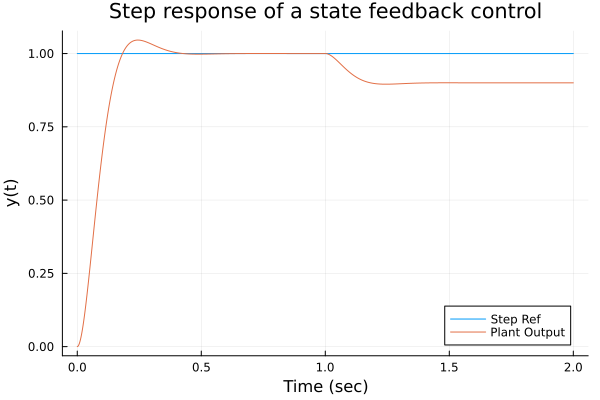

In [43]:
#State response of state feedback system
begin
    tvec = collect(0:0.001:2)
    midpts = trunc(Int, length(tvec)/2)
    dist_level = 0.1
    r = ones(size(tvec))
    rc = ffgain*r
    d = dist_level*ffgain*r
    d[1:midpts] .= 0.0
    u = rc - d
    u = reshape(u,(1,size(u)...))
    y, t, x = lsim(T_ss, u, tvec, method=:zoh)
    y = dropdims(y, dims=1)
    plot(t,r,label="Step Ref")
    plot!(t,y,label="Plant Output", xlabel="Time (sec)", ylabel="y(t)", title="Step response of a state feedback control", legend=:bottomright)
end

# Steady state error can be eliminated by augmenting an integrator

In [44]:
#Investigate Desired Poles
begin 
    ζ = 0.7
    ωₙ = 40
    Δ1 = s^2 + 2*ζ*ωₙ*s + ωₙ^2
    desired_poles = tzero(Δ1)
end

2-element Vector{ComplexF64}:
 -28.0 + 28.565713714171395im
 -28.0 - 28.565713714171395im

In [46]:
#Compute the required gains to place the poles at desired locations
K1 = real(place(P_ss, desired_poles))

1×2 Matrix{Float64}:
 16000.0  559.9

In [72]:
#feedforward gain
Tss_1 = ss(A-B*K1, B, C, D)
ffgain_1 = real((1 ./dcgain(T_ss1))[1])

15999.999999999996

In [73]:
#Open-Loop System
#[x_dot; w_dot] = [A 0;c 0] * [x; w] + [b; 0] * (u + d) + [0; -1] * r
Kᵢ = 200000;
begin
    A₁ = [A-B*K1 -Kᵢ*B]
    Cₐ = [C [0]]
    Aₐ = [A₁;Cₐ]
    B₁ = [B; 0]
    B₂ = [0;0;-1]
    Bₐ = [B₁ B₂]
    Dₐ = zeros(1,2)
    TSSₐ = ss(Aₐ,Bₐ,Cₐ,Dₐ)
end

StateSpace{Continuous, Float64}
A = 
     0.0                1.0      -0.0
 -1599.9999999999998  -56.0  -20000.0
     1.0                0.0       0.0
B = 
 0.0   0.0
 0.1   0.0
 0.0  -1.0
C = 
 1.0  0.0  0.0
D = 
 0.0  0.0

Continuous-time state-space model

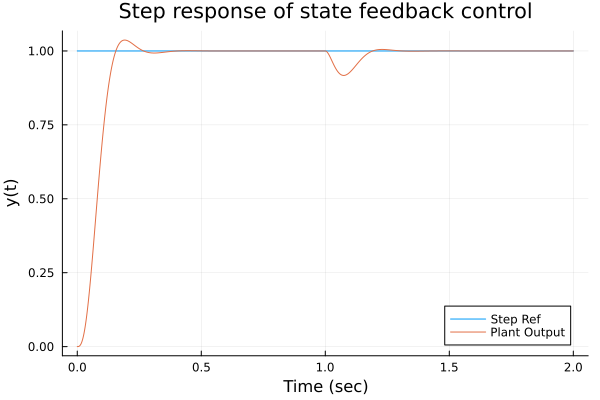

In [76]:
begin
    tvec = collect(0:0.001:2)
    midpts = trunc(Int,length(tvec)/2)
    dist_level = 0.1
    r = ones(size(tvec))
    d₁ = -dist_level * ffgain_1 * r
    d₁[1:midpts] .= 0.0
    u₁ = [d₁ r]' #add transpose
    #size(u₁)
    yₐ,tₐ,xₐ = lsim(TSSₐ, u₁, tvec, method=:zoh)
    plot(tₐ,r,label="Step Ref")
    yₐ = dropdims(yₐ, dims=1)
    plot!(tₐ,yₐ, label="Plant Output",xlabel="Time (sec)",ylabel="y(t)",
        title="Step response of state feedback control", legend=:bottomright) 
end